# Data Prep and Model Testing

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
healthy = pd.read_csv('data/healthy.csv', sep=';', decimal=',')
vae = pd.read_csv('data/vae.csv', sep=';', decimal=',')
ad = pd.read_csv('data/ad.csv', sep=';', decimal=',')

In [46]:
print('Healthy:', healthy.shape)
print('Vascular Encephalopathy :', vae.shape)
print('Alzheimers Disease:', ad.shape)

Healthy: (165, 19)
Vascular Encephalopathy : (129, 24)
Alzheimers Disease: (191, 24)


In [47]:
lab_healthy = list(np.repeat('Healthy', healthy.shape[0]))
lab_vae = list(np.repeat('VaE', vae.shape[0]))
lab_ad = list(np.repeat('AD', ad.shape[0]))

healthy.insert(healthy.shape[1], 'Diagnostic', lab_healthy)
vae.insert(vae.shape[1], 'Diagnostic', lab_vae)
ad.insert(ad.shape[1], 'Diagnostic', lab_ad)

In [48]:
data = pd.concat([healthy, vae, ad])
data.dropna(axis=1, inplace=True)
data.shape

(485, 11)

In [49]:
data = data.rename(columns={'Phonemic Fluency ': 'Pho_Fluency',
            'Semantic Fluency': 'Sem_Fluency',
            'Rey-Osterrieth Complex Figure - copy ': 'Rey_Copy',
            'Rey-Osterrieth Complex Figure - delayed recall ': 'Rey_DelayedRecall',
            "Raven's Progressive Matrices ": 'RavensPM',
            'TMT_B - dichotomised': 'TMT_B'})

data.head()

,ID,Age,Edu,Pho_Fluency,Sem_Fluency,Rey_Copy,Rey_DelayedRecall,RavensPM,TMT_A,TMT_B,Diagnostic
0,1,68.0,16.0,45.0,47.0,34.0,22.0,34.0,75.0,1.0,Healthy
1,2,71.0,17.0,36.0,43.0,29.0,15.0,33.0,34.0,1.0,Healthy
2,3,77.0,11.0,30.0,38.0,27.0,13.0,28.0,44.0,1.0,Healthy
3,4,73.0,13.0,43.0,53.0,31.0,16.5,35.0,50.0,1.0,Healthy
4,5,64.0,17.0,37.0,58.0,34.0,10.5,34.0,19.0,1.0,Healthy


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = data.iloc[:,1:data.shape[1]-1]
y = data['Diagnostic']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(388, 9) (97, 9) (388,) (97,)


In [51]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [52]:
from sklearn.metrics import accuracy_score
model = []
train_acc_scores = []
test_acc_scores = []

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


## *Logistic Regression*

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C=10, solver='lbfgs', multi_class='ovr', max_iter=1000)  # C is inverse regularization
lr.fit(X_train_std, y_train)



LogisticRegression(C=10, max_iter=1000, multi_class='ovr')

In [54]:
y_pred_train = lr.predict(X_train_std)
y_pred_test = lr.predict(X_test_std)

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


acc_train, acc_test = get_acc('Logistic Regression', y_pred_train, y_pred_test)
print('Accuracy Train:', acc_train,
      '\nAccuracy Test:', acc_test)


Accuracy Train: 0.825 
Accuracy Test: 0.773


## *Trees*

### *Decision Tree*

0.817 {'max_depth': 2}


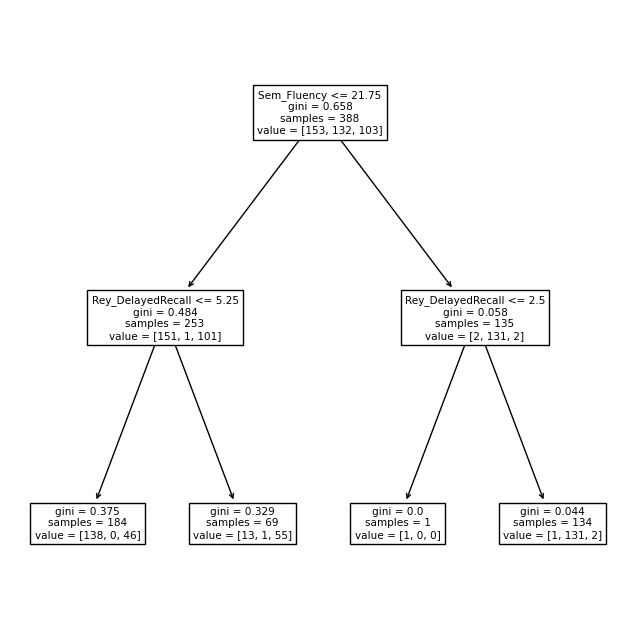

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

params = {'max_depth': range(2,10)}
dtc = DecisionTreeClassifier(criterion='gini', random_state=42)

gs = GridSearchCV(dtc, params, n_jobs=-1)
gs.fit(X_train, y_train)

tree_model = gs.best_estimator_
print(round(gs.best_score_, 3), gs.best_params_) 

plt.figure(figsize=(8, 8))
plot_tree(tree_model, feature_names=list(X_train.columns));



In [56]:
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


acc_train, acc_test = get_acc('Decision Tree', y_pred_train, y_pred_test)
print('Accuracy Train:', acc_train,
      '\nAccuracy Test:', acc_test)


Accuracy Train: 0.838 
Accuracy Test: 0.753


### *Random Forest*


In [57]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
          'max_depth': [2,3,4,5]}

rfc = RandomForestClassifier(random_state=42)

gs = GridSearchCV(rfc, params, n_jobs=-1)
gs.fit(X_train_std, y_train)

rfc_model = gs.best_estimator_

print(round(gs.best_score_, 3), gs.best_params_) 


0.815 {'max_depth': 3, 'n_estimators': 30}


In [58]:
y_pred_train = rfc_model.predict(X_train_std)
y_pred_test = rfc_model.predict(X_test_std)

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


acc_train, acc_test = get_acc('Random Forest', y_pred_train, y_pred_test)
print('Accuracy Train:', acc_train,
      '\nAccuracy Test:', acc_test)

Accuracy Train: 0.863 
Accuracy Test: 0.732


## *SVMs*

In [59]:
from sklearn.svm import SVC

params = {'kernel':['linear', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 2, 5, 10]}

svc = SVC(random_state=42)

gs = GridSearchCV(svc, params, n_jobs=-1)

gs.fit(X_train_std, y_train)

svm_model = gs.best_estimator_


print(round(gs.best_score_, 3), gs.best_params_) 


0.809 {'C': 2, 'kernel': 'rbf'}


In [60]:
y_pred_train = svm_model.predict(X_train_std)
y_pred_test = svm_model.predict(X_test_std)

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


acc_train, acc_test = get_acc('Support Vector Machine', y_pred_train, y_pred_test)
print('Accuracy Train:', acc_train,
      '\nAccuracy Test:', acc_test)

Accuracy Train: 0.874 
Accuracy Test: 0.763


## *KNNs*

In [61]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}

knn = KNeighborsClassifier(metric='minkowski', p=2)

gs = GridSearchCV(knn, params, n_jobs=-1)
gs.fit(X_train_std, y_train)

knn_model = gs.best_estimator_

print(round(gs.best_score_, 3), gs.best_params_) 

0.796 {'n_neighbors': 5}


In [62]:
y_pred_train = knn_model.predict(X_train_std)
y_pred_test = knn_model.predict(X_test_std)

def get_acc(model_name, y_pred_train, y_pred_test):
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 3)
    acc_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    model.append(model_name)
    train_acc_scores.append(acc_train)
    test_acc_scores.append(acc_test)
    
    return acc_train, acc_test


acc_train, acc_test = get_acc('K Nearest Neighbors', y_pred_train, y_pred_test)
print('Accuracy Train:', acc_train,
      '\nAccuracy Test:', acc_test)

Accuracy Train: 0.866 
Accuracy Test: 0.753


In [63]:
for x in range(len(model)):
    print('\nModel:', model[x],
          '\nTrain Accuracy:', train_acc_scores[x],
          '\nTest Accuracy:', test_acc_scores[x])


Model: Logistic Regression 
Train Accuracy: 0.825 
Test Accuracy: 0.773

Model: Decision Tree 
Train Accuracy: 0.838 
Test Accuracy: 0.753

Model: Random Forest 
Train Accuracy: 0.863 
Test Accuracy: 0.732

Model: Support Vector Machine 
Train Accuracy: 0.874 
Test Accuracy: 0.763

Model: K Nearest Neighbors 
Train Accuracy: 0.866 
Test Accuracy: 0.753


In [64]:
model_label = model*2
acc_type = ['Train', 'Train', 'Train', 'Train', 'Train',
            'Test', 'Test', 'Test', 'Test', 'Test']
accs = [x for x in train_acc_scores]
for x in test_acc_scores:
    accs.append(x)
    
d_acc = pd.DataFrame({'Model': model_label,
                      'Dataset': acc_type,
                      'Accuracy': accs})
   
    

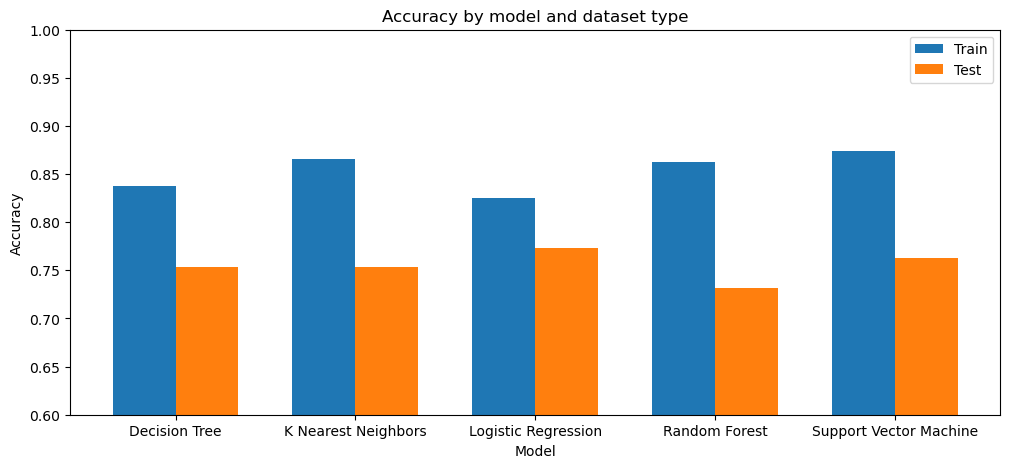

In [65]:
pivot_df = d_acc.pivot(index='Model', columns='Dataset', values='Accuracy')

fig, ax = plt.subplots(figsize=(12, 5))

positions = np.arange(len(pivot_df))
width = 0.35

train_bars = ax.bar(positions - width/2, pivot_df['Train'], width, label='Train')
test_bars = ax.bar(positions + width/2, pivot_df['Test'], width, label='Test')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and dataset type')
ax.set_xticks(positions)
ax.set_xticklabels(pivot_df.index)
ax.legend()
ax.set_ylim([0.6, 1])

plt.show();


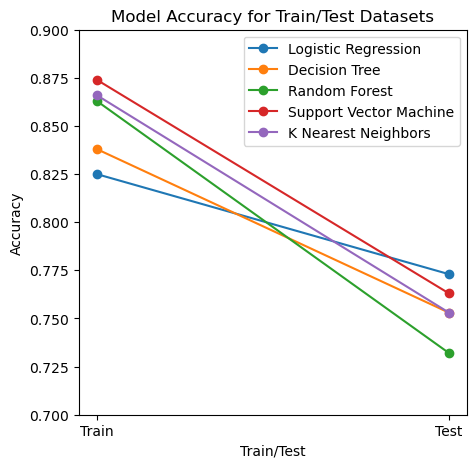

In [66]:
# Plotar o gráfico
fig, ax = plt.subplots(figsize=(5, 5))

# Usar um loop para plotar cada modelo com uma cor diferente
for model in d_acc['Model'].unique():
    model_data = d_acc[d_acc['Model'] == model]
    ax.plot(model_data['Dataset'], model_data['Accuracy'], label=model, marker='o')

# Configurar os rótulos e títulos dos eixos
ax.set_xlabel('Train/Test')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy for Train/Test Datasets')

# Adicionar legenda
ax.legend()

# Definir o limite do eixo Y
ax.set_ylim([0.7, 0.9])

# Mostrar o gráfico
plt.show()

### *Creating a unified pipeline*

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='mean')

pipe = Pipeline([
    ('ImputingMissing', si),
    ('Scaling', sc),
    ('SVM_Model', svm_model)
])


pipe.fit(X_train, y_train)

Pipeline(steps=[('ImputingMissing', SimpleImputer()),
                ('Scaling', StandardScaler()),
                ('SVM_Model', SVC(C=2, random_state=42))])

### *Saving the model*

In [67]:
import pickle as pk

with open('svm_model-0.1.0.pkl', 'wb') as file:
    pk.dump(pipe, file)
